# FCN 모델 학습

In [21]:

### Import Libraries
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import torch.nn.functional as F

In [2]:
#  check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 데이터셋 불러오기

In [3]:
### Load VOCSegmentation Dataset
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# 마스크 변환
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 마스크도 이미지와 동일한 크기로 리사이즈
    transforms.ToTensor()           # PIL 이미지를 Tensor로 변환
])

In [5]:
# VOCSegmentation 데이터셋 로드
dataset = VOCSegmentation(
    root='/kaggle/working/',
    year='2012',
    image_set='train',
    download=True,
    transform=image_transform,
    target_transform=mask_transform  # 마스크 변환 추가
)

100%|██████████| 2.00G/2.00G [01:04<00:00, 31.0MB/s] 


Extracting /kaggle/working/VOCtrainval_11-May-2012.tar to /kaggle/working/


In [6]:
# 첫 번째 데이터 확인
img, mask = dataset[0]
print(f"이미지 크기: {img.shape}")  # 예: torch.Size([3, 256, 256])
print(f"마스크 크기: {mask.shape}")  # 예: torch.Size([1, 256, 256])


이미지 크기: torch.Size([3, 256, 256])
마스크 크기: torch.Size([1, 256, 256])


In [7]:
# 데이터 분할
train_size = int(0.8 * len(dataset))  # 80%를 훈련 데이터로 사용
val_size = len(dataset) - train_size  # 나머지를 검증 데이터로 사용
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 데이터 크기 확인
print(f"훈련 데이터 크기: {len(train_dataset)}")
print(f"검증 데이터 크기: {len(val_dataset)}")

훈련 데이터 크기: 1171
검증 데이터 크기: 293


# 데이터로더

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [9]:
print(f"훈련 데이터 크기 (샘플 수): {len(train_dataset)}")
print(f"검증 데이터 크기 (샘플 수): {len(val_dataset)}")
print(f"훈련 데이터 배치 수: {len(train_loader)}")
print(f"검증 데이터 배치 수: {len(val_loader)}")

훈련 데이터 크기 (샘플 수): 1171
검증 데이터 크기 (샘플 수): 293
훈련 데이터 배치 수: 74
검증 데이터 배치 수: 19


# 모델

In [10]:
## VGG16 Backbone model

###########import##################
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import VGG16_Weights, vgg16


###################################

##############FCN##################
class FCN(nn.Module):
    def __init__(self, num_classes=21, mode="8s"):
        super(FCN, self).__init__()
        self.mode = mode


        ## Pretrain VGG16
        vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        features = list(vgg.features.children()) # VGG16의 Conv레이어 가져오기
        # features: Conv Layer + MaxPooling Layer(합성곱 기반 특징 추출 부분)
        # classifier: Fully Connected Layer(완전 연결 기반 분류 부분)
        # children(): Sequential 내에 포함된 각 레이어를 순서대로 반환하는 이터레이터 역활
        # VGG16은 13개의 합성곱 + 5개의 MaxPooling이 포함 -> list형태로 변환

        # Conv layers 가져오기 (pool5까지)
        # VGG16의 특정구간을 잘라서 할당
        self.conv1 = nn.Sequential(*features[:5])
        # Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

        self.conv2 = nn.Sequential(*features[5:10])
        # Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

        self.conv3 = nn.Sequential(*features[10:17])
        # Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

        self.conv4 = nn.Sequential(*features[17:24])
        # Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

        self.conv5 = nn.Sequential(*features[24:])
        # Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

        # Fully Convolutional Layers
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.score_fr = nn.Conv2d(4096, num_classes, 1)

        # 1x1 conv layers skip connections
        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)

        # Transposed Layer
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        # VGG16 Forward Pass
        x1 = self.conv1(x) #Feature Map 1
        x2 = self.conv2(x1) #Feature Map 2
        x3 = self.conv3(x2) #Feature Map 3
        x4 = self.conv4(x3) #Feature Map 4
        x5 = self.conv5(x4) #Feature Map 5



        # Fully Convolutional Layers
        x5 = self.relu(self.fc6(x5))
        x5 = self.dropout(x5)

        x5 = self.relu(self.fc7(x5))
        x5 = self.dropout(x5)

        score_fr = self.score_fr(x5)   # 최종 맵


        if self.mode == "16s":
            # FCN-16s: skip connection
            score_pool4 = self.score_pool4(x4)
            upscore2 = F.interpolate(score_fr, size=score_pool4.shape[2:], mode='bilinear', align_corners=False)
            fuse_pool4 = upscore2 + score_pool4  # Skip connection from pool4
            upscore16 = self.upscore16(fuse_pool4)  # Upsample to (224, 224)
            return F.interpolate(upscore16, size=x.shape[2:], mode='bilinear', align_corners=False)


        elif self.mode == "8s":
            # FCN-8s
            score_pool4 = self.score_pool4(x4)  # pool4: (14, 14)
            score_pool3 = self.score_pool3(x3)  # pool3: (28, 28)
            upscore2 = F.interpolate(score_fr, size=score_pool4.shape[2:], mode='bilinear', align_corners=False)
            fuse_pool4 = upscore2 + score_pool4  # Skip connection from pool4
            upscore2_pool4 = F.interpolate(fuse_pool4, size=score_pool3.shape[2:], mode='bilinear', align_corners=False)
            fuse_pool3 = upscore2_pool4 + score_pool3  # Skip connection from pool3
            upscore8 = self.upscore8(fuse_pool3)  # Upsample to (224, 224)
            return F.interpolate(upscore8, size=x.shape[2:], mode='bilinear', align_corners=False)

# 학습 및 검증

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(num_classes=21, mode="8s").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 196MB/s]  


In [13]:
# Early Stopping
### Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='/kaggle/working/checkpoint.pth', verbose=False):
        self.patience = patience # 손실 개선이 없더라도 기다리는 에포크 수
        self.delta = delta # 손실이 개선되었다고 간주할 최소 변화량
        self.path = path # 모델 가중치를 저장할 파일 경로
        self.verbose = verbose #로그 메시지 출력 여부
        self.counter = 0 # 개선되지 않은 에포크 수를 기록
        self.best_score = None # 최상의 검증 손실을 기록
        self.early_stop = False #조기 종료 플래그
        self.val_loss_min = np.Inf # 초기 검증 손실(무한대로 설정)

    def __call__(self, val_loss, model):
        score = -val_loss # 손실이 적을수록 좋은 결과이므로 음수로 변환
 
        if self.best_score is None:
            self.best_score = score # 첫 번째 에포크에서는 최상의 점수 초기화
            self.save_checkpoint(val_loss, model) # 모델 가중치 저장
        elif score < self.best_score + self.delta:
            self.counter += 1 # 개선되지 않았으므로 카운터 증가
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True # 조기 종료 조건 충족
        else:
            self.best_score = score # 최상의 점수를 갱신
            self.save_checkpoint(val_loss, model) #모델 가중치 저장
            self.counter = 0 # 개선되었으므로 카운터 초기화

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path) # 모델 가중치 저장
        self.val_loss_min = val_loss # 최상의 검증 손실 갱신

### Early Stopping Initialization
early_stopping = EarlyStopping(patience=7, verbose=True, path="/kaggle/working/best_model.pth")

# 학습루프

In [14]:
### Training and Validation Loop
# 손실 기록을 위한 리스트
train_losses = []
val_losses = []

# 학습 및 검증 루프
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # Training Loop
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).long()
        masks = masks.squeeze(1)
        optim.zero_grad()

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        running_train_loss += loss.item()

        # Backward Pass
        loss.backward()
        optim.step()

    # 평균 훈련 손실 계산
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).long()
            masks = masks.squeeze(1)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

### Load the Best Model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/30], Train Loss: 0.4386, Val Loss: 0.2273
Validation loss decreased (inf --> 0.227331).  Saving model ...
Epoch [2/30], Train Loss: 0.2047, Val Loss: 0.2591
EarlyStopping counter: 1 out of 7
Epoch [3/30], Train Loss: 0.1975, Val Loss: 0.2213
Validation loss decreased (0.227331 --> 0.221333).  Saving model ...
Epoch [4/30], Train Loss: 0.1901, Val Loss: 0.2158
Validation loss decreased (0.221333 --> 0.215787).  Saving model ...
Epoch [5/30], Train Loss: 0.1960, Val Loss: 0.2188
EarlyStopping counter: 1 out of 7
Epoch [6/30], Train Loss: 0.1857, Val Loss: 0.2162
EarlyStopping counter: 2 out of 7
Epoch [7/30], Train Loss: 0.1847, Val Loss: 0.2252
EarlyStopping counter: 3 out of 7
Epoch [8/30], Train Loss: 0.1824, Val Loss: 0.2150
Validation loss decreased (0.215787 --> 0.215009).  Saving model ...
Epoch [9/30], Train Loss: 0.1834, Val Loss: 0.2266
EarlyStopping counter: 1 out of 7
Epoch [10/30], Train Loss: 0.1829, Val Loss: 0.2099
Validation loss decreased (0.215009 --> 0.209943

<ipython-input-14-90a420c68957>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

# 시각화

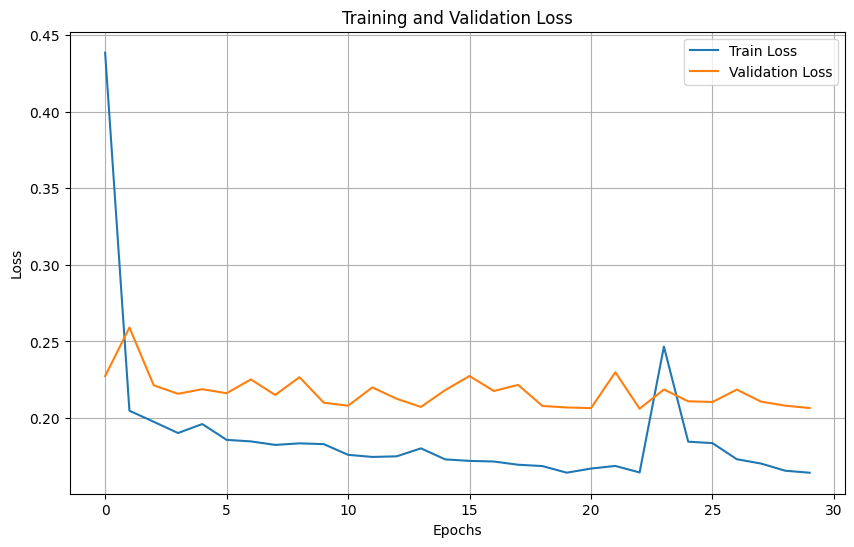

In [15]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    """
    훈련 및 검증 손실 그래프를 시각화하는 함수
    Args:
        train_losses (list): 각 에포크의 훈련 손실 리스트
        val_losses (list): 각 에포크의 검증 손실 리스트
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 손실 그래프 출력
plot_loss(train_losses, val_losses)


In [18]:
def visualize_segmentation(image, ground_truth, prediction, class_colors):
    """
    원본 이미지, 정답 마스크, 예측 마스크를 시각화
    Args:
        image (torch.Tensor): 원본 이미지 텐서 (C, H, W)
        ground_truth (torch.Tensor): 정답 마스크 텐서 (H, W)
        prediction (torch.Tensor): 예측 마스크 텐서 (H, W)
        class_colors (list): 클래스별 RGB 색상 리스트
    """
    # Tensor를 NumPy 배열로 변환
    image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    image = (image * 0.5 + 0.5) * 255  # 정규화 해제 및 0~255로 변환
    image = image.astype(np.uint8)

    ground_truth = ground_truth.cpu().numpy()
    prediction = prediction.cpu().numpy()

    # 마스크를 RGB로 변환
    ground_truth_rgb = np.zeros((*ground_truth.shape, 3), dtype=np.uint8)
    prediction_rgb = np.zeros((*prediction.shape, 3), dtype=np.uint8)

    for class_id, color in enumerate(class_colors):
        ground_truth_rgb[ground_truth == class_id] = color
        prediction_rgb[prediction == class_id] = color

    # 첫 번째 차원이 존재할 경우 제거
    if ground_truth_rgb.ndim == 4:
        ground_truth_rgb = ground_truth_rgb.squeeze(0)
    if prediction_rgb.ndim == 4:
        prediction_rgb = prediction_rgb.squeeze(0)

    # 시각화
    plt.figure(figsize=(15, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    # 정답 마스크
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth_rgb)
    plt.axis('off')

    # 예측 마스크
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction_rgb)
    plt.axis('off')

    plt.show()


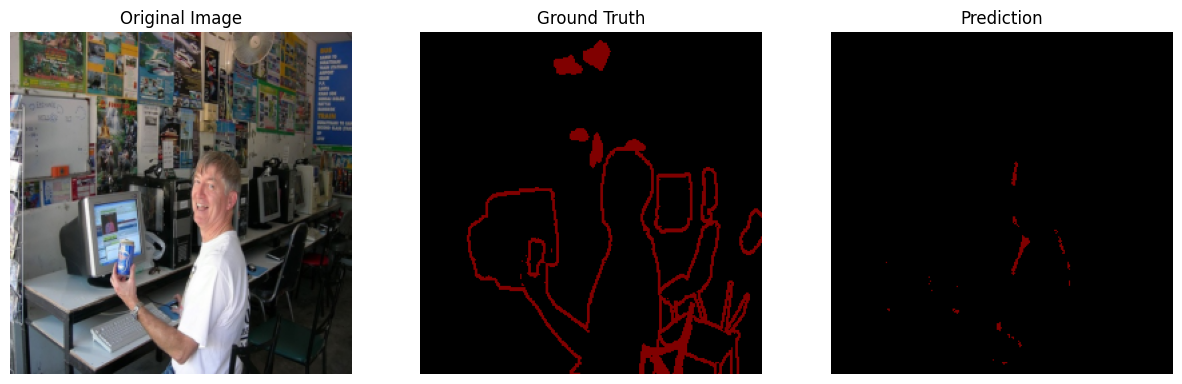

In [20]:
# 클래스 색상 정의
class_colors = [
    [0, 0, 0],       # Background
    [128, 0, 0],     # Class 1
    [0, 128, 0],     # Class 2
    [128, 128, 128],   # Class 3
    # ... 다른 클래스 색상 추가
]

# 모델 평가 모드 전환
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        # 이미지와 마스크를 디바이스로 이동
        images, masks = images.to(device).float(), masks.to(device).long()

        # 모델 예측
        outputs = model(images)  # 모델 출력
        predictions = torch.argmax(outputs, dim=1)  # 가장 높은 확률의 클래스를 선택

        # 첫 번째 샘플 시각화
        visualize_segmentation(images[0], masks[0], predictions[0], class_colors)
        break


# 개선방안 2번 Regularization
* L2 Regularization (Weight Decay): 모델의 가중치 값을 작게 유지하여 과적합을 방지.
* Dropout: 일부 뉴런을 랜덤으로 비활성화하여 모델이 특정 경로에 의존하지 않도록 함

In [21]:
# 모델의 Dropout 적용
class FCN(nn.Module):
    def __init__(self, num_classes=21, mode="8s"):
        super(FCN, self).__init__()
        self.mode = mode

        # Pretrained VGG16
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        features = list(vgg.features.children())
        self.conv1 = nn.Sequential(*features[:5])
        self.conv2 = nn.Sequential(*features[5:10])
        self.conv3 = nn.Sequential(*features[10:17])
        self.conv4 = nn.Sequential(*features[17:24])
        self.conv5 = nn.Sequential(*features[24:])

        # Fully Convolutional Layers
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.5)  # Dropout 추가

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.score_fr = nn.Conv2d(4096, num_classes, 1)

        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        x5 = self.relu(self.fc6(x5))
        x5 = self.dropout(x5)  # Dropout 적용

        x5 = self.relu(self.fc7(x5))
        x5 = self.dropout(x5)  # Dropout 적용

        score_fr = self.score_fr(x5)

        score_pool4 = self.score_pool4(x4)
        score_pool3 = self.score_pool3(x3)

        upscore2 = F.interpolate(score_fr, size=score_pool4.shape[2:], mode='bilinear', align_corners=False)
        fuse_pool4 = upscore2 + score_pool4

        upscore_pool4 = F.interpolate(fuse_pool4, size=score_pool3.shape[2:], mode='bilinear', align_corners=False)
        fuse_pool3 = upscore_pool4 + score_pool3

        upscore8 = self.upscore8(fuse_pool3)
        return F.interpolate(upscore8, size=x.shape[2:], mode='bilinear', align_corners=False)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(num_classes=21, mode="8s").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [23]:
# 훈련 및 검증 루프
train_losses = []
val_losses = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()  # Dropout 활성화
    running_train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).long()
        masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        running_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()  # Dropout 비활성화
    running_val_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).long()
            masks = masks.squeeze(1)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/30], Train Loss: 0.4286, Val Loss: 0.2423
Epoch [2/30], Train Loss: 0.2016, Val Loss: 0.2279
Epoch [3/30], Train Loss: 0.1977, Val Loss: 0.2173
Epoch [4/30], Train Loss: 0.1950, Val Loss: 0.2285
Epoch [5/30], Train Loss: 0.1872, Val Loss: 0.2162
Epoch [6/30], Train Loss: 0.1935, Val Loss: 0.2224
Epoch [7/30], Train Loss: 0.1888, Val Loss: 0.2124
Epoch [8/30], Train Loss: 0.1882, Val Loss: 0.2285
Epoch [9/30], Train Loss: 0.1851, Val Loss: 0.2490
Epoch [10/30], Train Loss: 0.1908, Val Loss: 0.2117
Epoch [11/30], Train Loss: 0.1822, Val Loss: 0.2142
Epoch [12/30], Train Loss: 0.1802, Val Loss: 0.2327
Epoch [13/30], Train Loss: 0.1811, Val Loss: 0.2096
Epoch [14/30], Train Loss: 0.1742, Val Loss: 0.2090
Epoch [15/30], Train Loss: 0.1813, Val Loss: 0.2123
Epoch [16/30], Train Loss: 0.1790, Val Loss: 0.2125
Epoch [17/30], Train Loss: 0.2038, Val Loss: 0.2122
Epoch [18/30], Train Loss: 0.2368, Val Loss: 0.2574
Epoch [19/30], Train Loss: 0.1903, Val Loss: 0.2123
Epoch [20/30], Train 

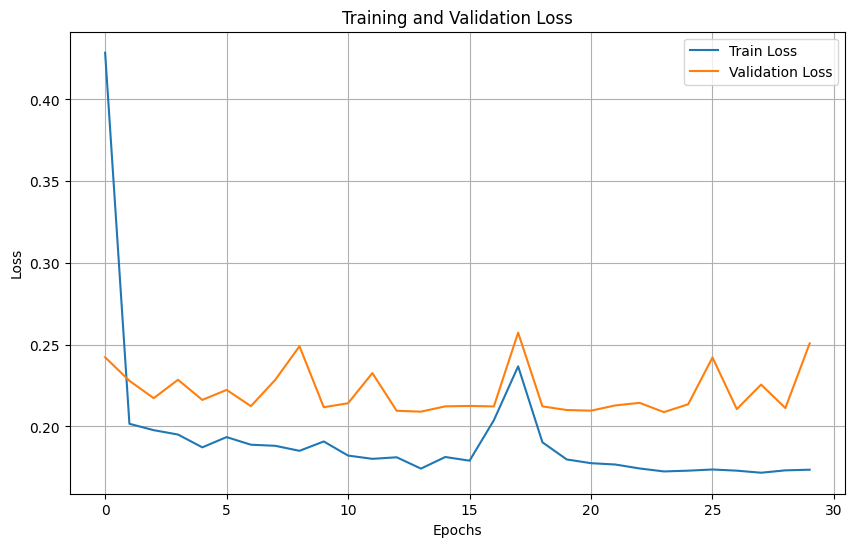

In [24]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    """
    훈련 및 검증 손실 그래프를 시각화하는 함수
    Args:
        train_losses (list): 각 에포크의 훈련 손실 리스트
        val_losses (list): 각 에포크의 검증 손실 리스트
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 손실 그래프 출력
plot_loss(train_losses, val_losses)


In [28]:
def visualize_segmentation(image, ground_truth, prediction, class_colors):
    """
    원본 이미지, 정답 마스크, 예측 마스크를 시각화
    Args:
        image (torch.Tensor): 원본 이미지 텐서 (C, H, W)
        ground_truth (torch.Tensor): 정답 마스크 텐서 (H, W)
        prediction (torch.Tensor): 예측 마스크 텐서 (H, W)
        class_colors (list): 클래스별 RGB 색상 리스트
    """
    # Tensor를 NumPy 배열로 변환
    image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    image = (image * 0.5 + 0.5) * 255  # 정규화 해제 및 0~255로 변환
    image = image.astype(np.uint8)

    ground_truth = ground_truth.cpu().numpy()
    prediction = prediction.cpu().numpy()

    # 마스크를 RGB로 변환
    ground_truth_rgb = np.zeros((*ground_truth.shape, 3), dtype=np.uint8)
    prediction_rgb = np.zeros((*prediction.shape, 3), dtype=np.uint8)

    for class_id, color in enumerate(class_colors):
        ground_truth_rgb[ground_truth == class_id] = color
        prediction_rgb[prediction == class_id] = color

    # 첫 번째 차원이 존재할 경우 제거
    if ground_truth_rgb.ndim == 4:
        ground_truth_rgb = ground_truth_rgb.squeeze(0)
    if prediction_rgb.ndim == 4:
        prediction_rgb = prediction_rgb.squeeze(0)

    # 시각화
    plt.figure(figsize=(15, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    # 정답 마스크
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth_rgb)
    plt.axis('off')

    # 예측 마스크
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction_rgb)
    plt.axis('off')

    plt.show()


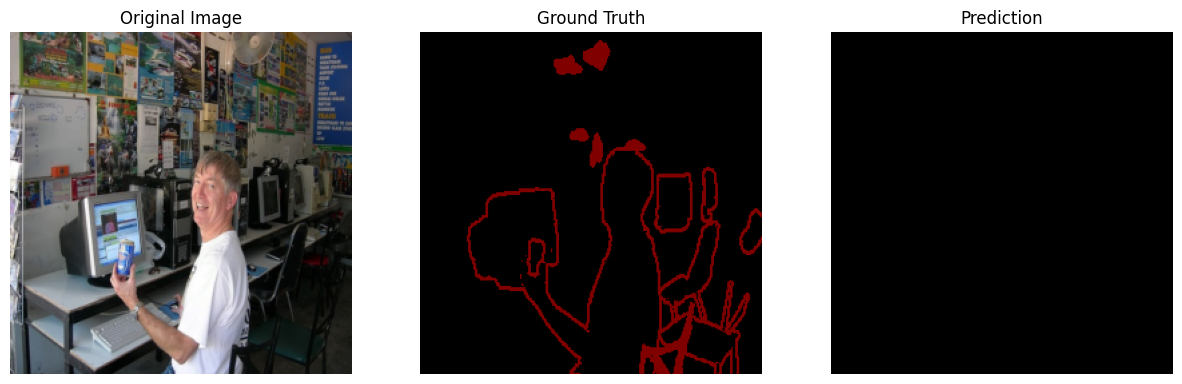

In [31]:
# 클래스 색상 정의
class_colors = [
    [0, 0, 0],       # Background
    [128, 0, 0],     # Class 1
    [0, 128, 0],     # Class 2
    [128, 128, 0],   # Class 3
    # ... 다른 클래스 색상 추가
]

# 모델 평가 모드 전환
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        # 이미지와 마스크를 디바이스로 이동
        images, masks = images.to(device).float(), masks.to(device).long()

        # 모델 예측
        outputs = model(images)  # 모델 출력
        predictions = torch.argmax(outputs, dim=1)  # 가장 높은 확률의 클래스를 선택

        # 첫 번째 샘플 시각화
        visualize_segmentation(images[0], masks[0], predictions[0], class_colors)
        break


# 개선방안 3번 Data Augmentation

In [47]:

### Import Libraries
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import torch.nn.functional as F

In [65]:
class VOCSegmentationCustom(VOCSegmentation):
    def __init__(self, root, year='2012', image_set='train', download=False, transform=None, mask_transform=None):
        super().__init__(root=root, year=year, image_set=image_set, download=download, transform=transform)
        self.mask_transform = mask_transform

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        
        # 이미지 변환 적용
        if self.transform and isinstance(image, torch.Tensor) is False:
            image = self.transform(image)
        
        # 마스크 변환 적용
        if self.mask_transform and isinstance(target, torch.Tensor) is False:
            target = self.mask_transform(target).long().squeeze(0)  # (H, W)
        
        return image, target


In [66]:
train_image_transform = transforms.Compose([
    transforms.Resize((256, 256)), # 고정크기로 조정
    transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우반전
    transforms.RandomRotation(10), # -10도 ~ + 10도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #색상
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize((0.5,), (0.5,)) # 정규화
 ])

In [67]:
val_image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [68]:
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 크기 조정
    transforms.ToTensor()  # 텐서 변환 (정규화 없음)
])

In [69]:
# 데이터셋 로드
root = '/kaggle/working/'
train_dataset = VOCSegmentationCustom(root=root, year='2012', image_set='train', download=True,
                                      transform=train_image_transform, mask_transform=mask_transform)
val_dataset = VOCSegmentationCustom(root=root, year='2012', image_set='val', download=False,
                                    transform=val_image_transform, mask_transform=mask_transform)


Using downloaded and verified file: /kaggle/working/VOCtrainval_11-May-2012.tar
Extracting /kaggle/working/VOCtrainval_11-May-2012.tar to /kaggle/working/


In [71]:
# DataLoader 생성
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [72]:
# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='/kaggle/working/best_model.pth', verbose=False):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [73]:
# FCN 모델 정의 (Dropout 포함)
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import VGG16_Weights, vgg16

class FCN(nn.Module):
    def __init__(self, num_classes=21, mode="8s"):
        super(FCN, self).__init__()
        self.mode = mode

        # Pretrained VGG16
        vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
        features = list(vgg.features.children())
        self.conv1 = nn.Sequential(*features[:5])
        self.conv2 = nn.Sequential(*features[5:10])
        self.conv3 = nn.Sequential(*features[10:17])
        self.conv4 = nn.Sequential(*features[17:24])
        self.conv5 = nn.Sequential(*features[24:])

        # Fully Convolutional Layers
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.5)  # Dropout 추가
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.score_fr = nn.Conv2d(4096, num_classes, 1)

        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        x5 = self.relu(self.fc6(x5))
        x5 = self.dropout(x5)  # Dropout 적용
        x5 = self.relu(self.fc7(x5))
        x5 = self.dropout(x5)  # Dropout 적용

        score_fr = self.score_fr(x5)
        score_pool4 = self.score_pool4(x4)
        score_pool3 = self.score_pool3(x3)

        upscore2 = F.interpolate(score_fr, size=score_pool4.shape[2:], mode='bilinear', align_corners=False)
        fuse_pool4 = upscore2 + score_pool4

        upscore_pool4 = F.interpolate(fuse_pool4, size=score_pool3.shape[2:], mode='bilinear', align_corners=False)
        fuse_pool3 = upscore_pool4 + score_pool3

        upscore8 = self.upscore8(fuse_pool3)
        return F.interpolate(upscore8, size=x.shape[2:], mode='bilinear', align_corners=False)


In [74]:
import torchvision
#  check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [75]:
# 모델 및 옵티마이저 설정
model = FCN(num_classes=21, mode="8s").to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization 포함
criterion = nn.CrossEntropyLoss(ignore_index=255)  # 손실 함수

In [76]:
# Early Stopping 초기화
early_stopping = EarlyStopping(patience=5, verbose=True, path='/kaggle/working/best_model.pth')

In [77]:
# 학습 루프
train_losses = []
val_losses = []
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).long()
        masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        running_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).long()
            masks = masks.squeeze(1)

            outputs = model(images)
            val_loss = criterion(outputs, masks)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# 최종 모델 저장
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

Epoch [1/30], Train Loss: 0.3528, Val Loss: 0.2323
Validation loss decreased (inf --> 0.232290). Saving model ...
Epoch [2/30], Train Loss: 0.2133, Val Loss: 0.2018
Validation loss decreased (0.232290 --> 0.201784). Saving model ...
Epoch [3/30], Train Loss: 0.2142, Val Loss: 0.2023
EarlyStopping counter: 1 out of 5
Epoch [4/30], Train Loss: 0.2116, Val Loss: 0.2011
Validation loss decreased (0.201784 --> 0.201060). Saving model ...
Epoch [5/30], Train Loss: 0.2121, Val Loss: 0.2213
EarlyStopping counter: 1 out of 5
Epoch [6/30], Train Loss: 0.2110, Val Loss: 0.1996
Validation loss decreased (0.201060 --> 0.199571). Saving model ...
Epoch [7/30], Train Loss: 0.2097, Val Loss: 0.2197
EarlyStopping counter: 1 out of 5
Epoch [8/30], Train Loss: 0.2161, Val Loss: 0.2085
EarlyStopping counter: 2 out of 5
Epoch [9/30], Train Loss: 0.2089, Val Loss: 0.2136
EarlyStopping counter: 3 out of 5
Epoch [10/30], Train Loss: 0.2114, Val Loss: 0.2009
EarlyStopping counter: 4 out of 5
Epoch [11/30], Tra

<ipython-input-77-281191b2c47c>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


<All keys matched successfully>

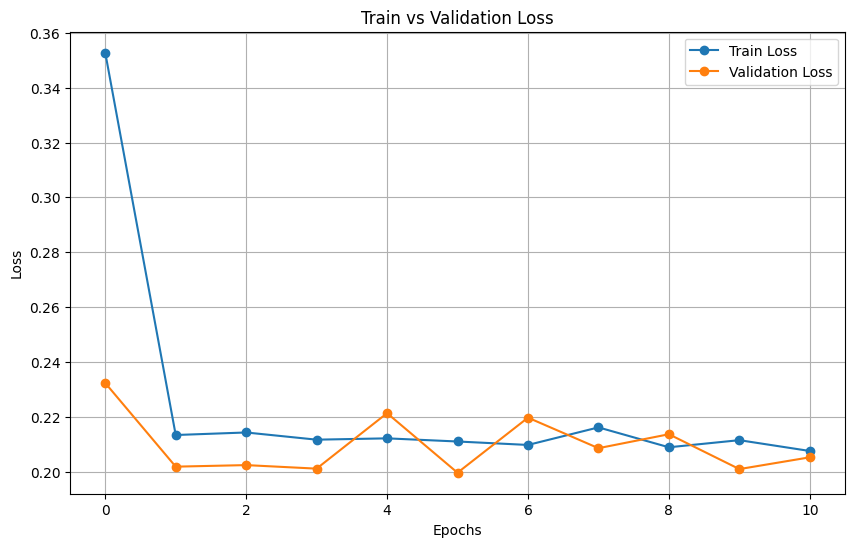

In [79]:
# 손실 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [80]:
def visualize_segmentation(image, ground_truth, prediction, class_colors):
    """
    원본 이미지, 정답 마스크, 예측 마스크를 시각화
    Args:
        image (torch.Tensor): 원본 이미지 텐서 (C, H, W)
        ground_truth (torch.Tensor): 정답 마스크 텐서 (H, W)
        prediction (torch.Tensor): 예측 마스크 텐서 (H, W)
        class_colors (list): 클래스별 RGB 색상 리스트
    """
    # Tensor를 NumPy 배열로 변환
    image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    image = (image * 0.5 + 0.5) * 255  # 정규화 해제 및 0~255로 변환
    image = image.astype(np.uint8)

    ground_truth = ground_truth.cpu().numpy()
    prediction = prediction.cpu().numpy()

    # 마스크를 RGB로 변환
    ground_truth_rgb = np.zeros((*ground_truth.shape, 3), dtype=np.uint8)
    prediction_rgb = np.zeros((*prediction.shape, 3), dtype=np.uint8)

    for class_id, color in enumerate(class_colors):
        ground_truth_rgb[ground_truth == class_id] = color
        prediction_rgb[prediction == class_id] = color

    # 시각화
    plt.figure(figsize=(15, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    # 정답 마스크
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth_rgb)
    plt.axis('off')

    # 예측 마스크
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction_rgb)
    plt.axis('off')

    plt.show()


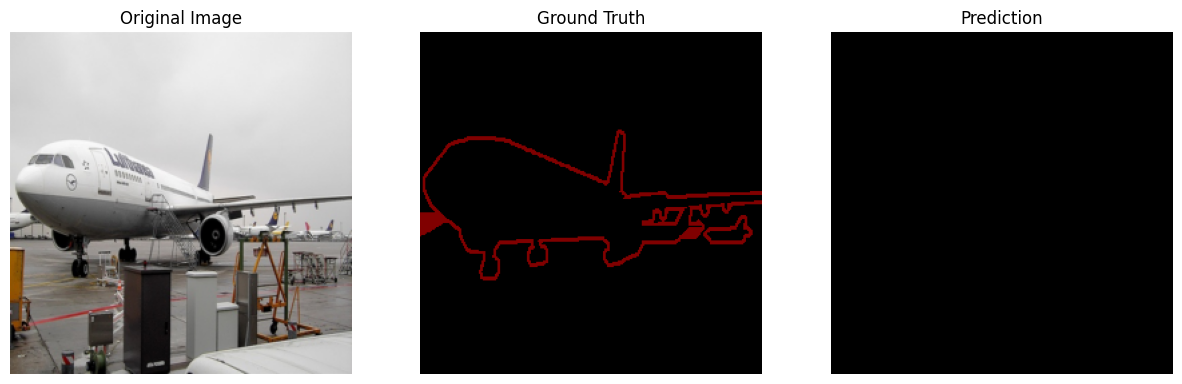

In [81]:
# 클래스 색상 정의 (PASCAL VOC 기준)
class_colors = [
    [0, 0, 0],       # Background
    [128, 0, 0],     # Class 1
    [0, 128, 0],     # Class 2
    [128, 128, 0],   # Class 3
    # ... 추가 클래스 색상
]

# 모델 평가 모드
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        # 이미지와 마스크를 디바이스로 이동
        images, masks = images.to(device), masks.to(device).long()

        # 모델 예측
        outputs = model(images)  # 모델 출력
        predictions = torch.argmax(outputs, dim=1)  # 가장 높은 확률의 클래스를 선택

        # 첫 번째 샘플 시각화
        visualize_segmentation(images[0], masks[0], predictions[0], class_colors)
        break
